In [30]:
from pathlib import Path

import numpy as np
import pandas as pd
import jsonpickle

import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
RUNDIR = "../output"
RUNID = "20240215_110400"

In [32]:
config_files = list(Path(RUNDIR).glob(f"{RUNID}*.config.json"))
print(f"Found {len(config_files)} config files")

Found 20 config files


In [33]:
configs = {}
dfs = {}
for config_file in config_files:
    config = jsonpickle.decode(config_file.read_text())
    data_file = Path(RUNDIR, config_file.name.split(".")[0] + ".csv")
    sub_id = config_file.name.split(".")[0].split("_")[-1]
    
    data = pd.read_csv(data_file)
    data["id"] = sub_id
    data["algorithm"] = config["algorithm"]
    data["dataset"] = config["dataset"]
    data["imbalance"] = config["imbalance_type"]
    data["imbalance_val"] = config["imbalance_value"]
    data["is_last_round"] = data["round"] == (config["rounds"] - 1)
    
    if sub_id in configs:
        print("Duplicate id!")
    dfs[sub_id] = data
    configs[sub_id] = config
    
data = pd.concat(dfs.values(), axis=0)
cluster_assignments = data.query("stage == 'test' and variable == 'cluster_identities'") 
data = data.query("variable != 'cluster_identities'")
data["value"] = data["value"].astype(float)

In [34]:
configs["0"]

{'algorithm': 'FedProx',
 'dataset': 'mnist',
 'rounds': 200,
 'epochs': 5,
 'n_clients': 100,
 'clients_per_round': 1.0,
 'imbalance_type': 'label_distribution',
 'imbalance_value': 10.0,
 'penalty': 0.2}

In [35]:
data["variable"].unique()

array(['loss', 'n_samples', 'f1'], dtype=object)

In [36]:
data = data.pivot_table(values = "value", index = ["round", "client", "stage", "id", "algorithm", "dataset", "imbalance", "imbalance_val", "is_last_round"], columns = ["variable"]).reset_index()
data.head()

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
0,0,0,test,10,local,mnist,label_distribution,10.0,False,0.033936,0.020115,114.0
1,0,0,test,11,local,mnist,label_distribution,0.1,False,0.000000,0.026228,89.0
2,0,0,test,12,FLSC,mnist,label_distribution,0.1,False,0.087719,2.287459,89.0
3,0,0,test,13,IFCA,mnist,label_distribution,0.5,False,0.063780,2.261005,174.0
4,0,0,test,15,FLSC,mnist,label_distribution,10.0,False,0.008403,2.310078,114.0


In [37]:
df = data.query("stage == 'test' and algorithm == 'FedProx'")
df["weighted_f1"] = df["f1"] * df["n_samples"]
df["weighted_loss"] = df["loss"] * df["n_samples"]
df = df.drop(columns=["client", "stage", "id", "dataset", "imbalance", "is_last_round", "algorithm"])\
    .groupby(["round", "imbalance_val"])\
    .sum()\
    .reset_index()

df["weighted_f1"] = df["weighted_f1"] / df["n_samples"]
df["weighted_loss"] = df["weighted_loss"] / df["n_samples"]

df = df.drop(columns=["loss", "f1"])
df

/tmp/ipykernel_13657/3625245082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weighted_f1"] = df["f1"] * df["n_samples"]
/tmp/ipykernel_13657/3625245082.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weighted_loss"] = df["loss"] * df["n_samples"]


variable,round,imbalance_val,n_samples,weighted_f1,weighted_loss
0,1,0.1,8221.0,0.105131,2.225434
1,1,0.5,7641.0,0.041769,2.282869
2,1,1.0,7357.0,0.095163,2.282491
3,1,10.0,7454.0,0.042784,2.287439
4,2,0.1,7595.0,0.165154,2.105673
...,...,...,...,...,...
795,199,10.0,7377.0,0.845444,0.468583
796,200,0.1,8851.0,0.571567,0.251180
797,200,0.5,7330.0,0.744870,0.286726
798,200,1.0,7798.0,0.777828,0.371108


<Axes: xlabel='round', ylabel='weighted_f1'>

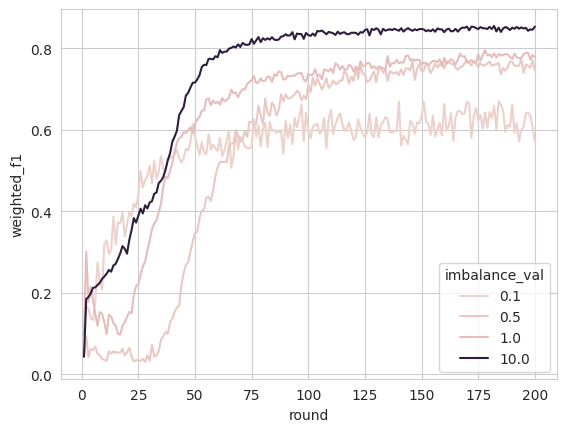

In [38]:
sns.lineplot(df, x = "round", y="weighted_f1", hue="imbalance_val")

<Axes: xlabel='round', ylabel='weighted_loss'>

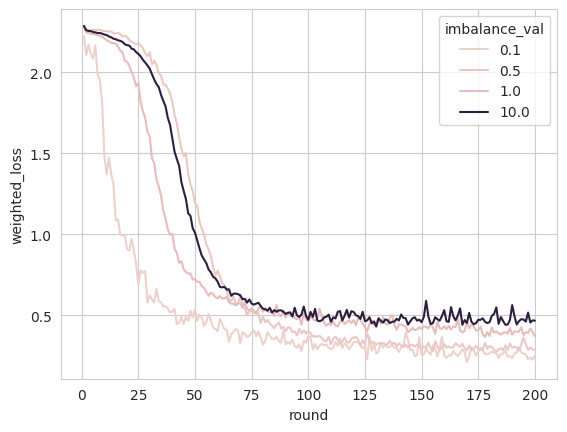

In [39]:
sns.lineplot(df, x = "round", y="weighted_loss", hue="imbalance_val")

<Axes: xlabel='round', ylabel='loss'>

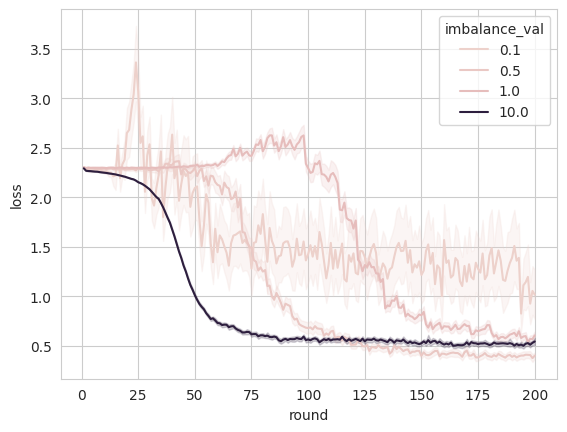

In [40]:
df = data.query("stage == 'train' and algorithm == 'FedAvg'")
sns.lineplot(df, x = "round", y = "loss", hue = "imbalance_val")

<Axes: xlabel='round', ylabel='f1'>

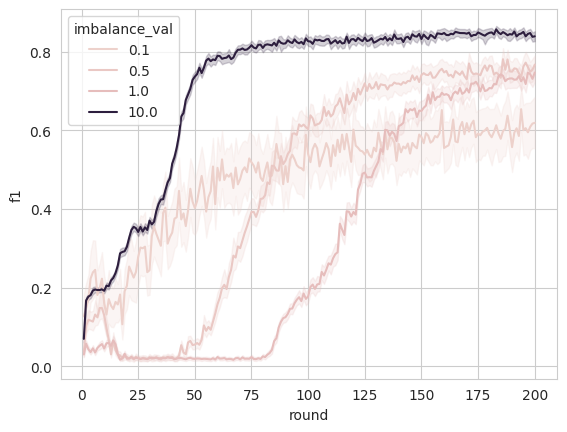

In [41]:
df = data.query("stage == 'test' and algorithm == 'FedAvg'")
sns.lineplot(df, x = "round", y = "f1", hue = "imbalance_val")

In [42]:
df_last = data.query("stage == 'test' and is_last_round")
df_last

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
678956,199,0,test,0,FedProx,mnist,label_distribution,10.0,True,0.888698,0.354234,114.0
678957,199,0,test,10,local,mnist,label_distribution,10.0,True,0.891835,0.003911,114.0
678958,199,0,test,11,local,mnist,label_distribution,0.1,True,0.701754,0.004846,89.0
678959,199,0,test,12,FLSC,mnist,label_distribution,0.1,True,0.000000,2.903519,89.0
678960,199,0,test,13,IFCA,mnist,label_distribution,0.5,True,0.639887,0.624057,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...
682352,199,99,test,5,IFCA,mnist,label_distribution,1.0,True,0.932497,0.032570,130.0
682353,199,99,test,6,FLSC,mnist,label_distribution,0.5,True,0.676399,0.511003,153.0
682354,199,99,test,7,FedAvg,mnist,label_distribution,0.5,True,0.834495,0.222974,153.0
682355,199,99,test,8,IFCA,mnist,label_distribution,10.0,True,0.913056,0.265936,134.0


Text(0.5, 1.0, 'Avg. F1 scores by imbalance param')

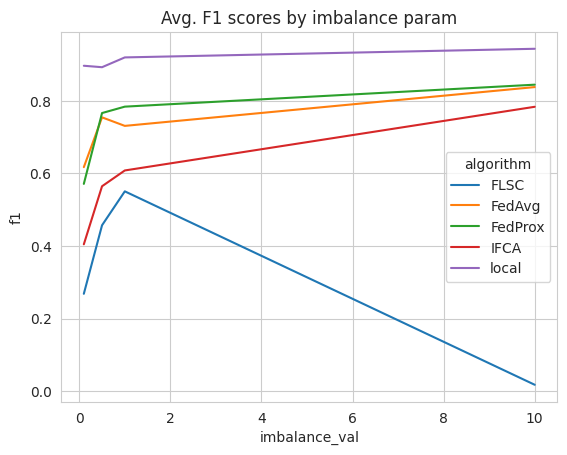

In [66]:
df_last_avg = df_last.groupby(["imbalance", "imbalance_val", "algorithm"]).mean(["f1", "loss"]).reset_index()\
    .query("imbalance == 'label_distribution'")
sns.lineplot(df_last_avg, x="imbalance_val", y="f1", hue='algorithm')
plt.title("Avg. F1 scores by imbalance param")

In [94]:
algorithms = set(df_last["algorithm"].unique()).difference({"local", "global"})
benefits = df_last.reset_index(drop=True)[["stage", "round", "client", "algorithm", "dataset", "imbalance", "imbalance_val", "f1"]]
benefits = benefits.pivot(columns="algorithm", values="f1", index=["stage", "round", "client", "dataset", "imbalance", "imbalance_val"]).reset_index()
benefits

algorithm,stage,round,client,dataset,imbalance,imbalance_val,FLSC,FedAvg,FedProx,IFCA,local
0,test,199,0,mnist,label_distribution,0.1,0.000000,0.559472,NaN,0.063123,0.701754
1,test,199,0,mnist,label_distribution,0.5,0.496786,NaN,0.838746,0.639887,0.706215
2,test,199,0,mnist,label_distribution,1.0,0.493843,0.715405,NaN,0.596798,0.614112
3,test,199,0,mnist,label_distribution,10.0,0.021875,0.885524,0.888698,0.822367,0.891835
4,test,199,1,mnist,label_distribution,0.1,0.246377,NaN,0.264289,0.246377,0.726604
...,...,...,...,...,...,...,...,...,...,...,...
395,test,199,98,mnist,label_distribution,10.0,0.028125,NaN,NaN,0.898757,0.962665
396,test,199,99,mnist,label_distribution,0.1,1.000000,1.000000,NaN,1.000000,0.995083
397,test,199,99,mnist,label_distribution,0.5,0.676399,0.834495,0.916400,0.753755,0.996899
398,test,199,99,mnist,label_distribution,1.0,0.832333,0.851544,0.932497,0.932497,0.864082


In [44]:
local = df_last.query("algorithm == 'local'")[["client","imbalance","imbalance_val","f1"]]
fedavg = df_last.query("algorithm == 'FedAvg'")[["client","imbalance","imbalance_val","f1"]]
fedprox = df_last.query("algorithm == 'FedProx'")[["client","imbalance","imbalance_val","f1"]]
ifca = df_last.query("algorithm == 'IFCA'")[["client","imbalance","imbalance_val","f1"]]
flsc = df_last.query("algorithm == 'FLSC'")[["client","imbalance","imbalance_val","f1"]]

In [45]:
f1scores = ifca.merge(flsc, on=["client", "imbalance", "imbalance_val"], suffixes=["_ifca", "_flsc"])\
    .merge(fedavg, on=["client", "imbalance", "imbalance_val"])\
    .merge(local, on=["client", "imbalance", "imbalance_val"], suffixes=["_fedavg", "_local"])\
    .merge(fedprox, on=["client", "imbalance", "imbalance_val"])\
    .rename(columns={"f1": "f1_fedprox"})
f1scores = f1scores.query("imbalance == 'label_distribution'")
f1scores

variable,client,imbalance,imbalance_val,f1_ifca,f1_flsc,f1_fedavg,f1_local,f1_fedprox
0,0,label_distribution,10.0,0.822367,0.021875,0.885524,0.891835,0.888698
1,1,label_distribution,1.0,0.504304,0.449049,0.532118,0.777392,0.555324
2,2,label_distribution,0.1,0.405647,0.063185,0.725680,0.994620,0.720784
3,3,label_distribution,0.5,0.528198,0.241804,0.906028,1.000000,0.906028
4,3,label_distribution,0.1,0.113158,0.054545,0.850952,0.669841,0.839103
...,...,...,...,...,...,...,...,...
155,97,label_distribution,1.0,0.520187,0.504533,0.673693,0.970909,0.730950
156,98,label_distribution,0.1,0.424330,0.325423,0.577787,1.000000,0.726753
157,99,label_distribution,0.5,0.753755,0.676399,0.834495,0.996899,0.916400
158,99,label_distribution,1.0,0.932497,0.832333,0.851544,0.864082,0.932497


In [46]:
f1scores["benefit_fedavg"] = f1scores["f1_fedavg"] - f1scores["f1_local"]
f1scores["benefit_fedprox"] = f1scores["f1_fedprox"] - f1scores["f1_local"]
f1scores["benefit_ifca"] = f1scores["f1_ifca"] - f1scores["f1_local"]
f1scores["benefit_flsc"] = f1scores["f1_flsc"] - f1scores["f1_local"]

In [47]:
benefits = f1scores.drop(columns=["f1_local", "f1_fedavg", "f1_ifca", "f1_flsc", "f1_fedprox"]).melt(id_vars=["client", "imbalance", "imbalance_val"], value_name="client_benefit", var_name="algorithm")

<Axes: xlabel='client_benefit', ylabel='Count'>

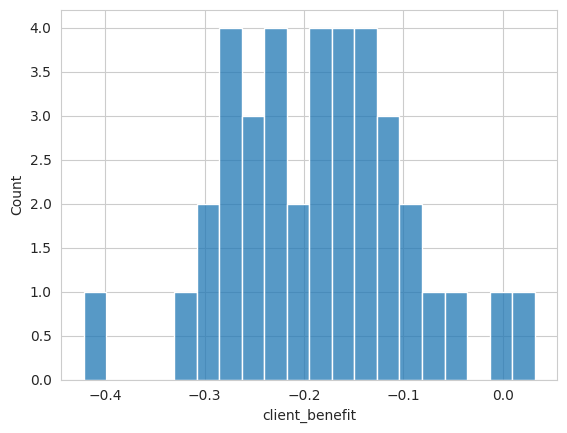

In [48]:
sns.histplot(benefits.query("algorithm == 'benefit_fedavg' and imbalance_val == 1"), x = "client_benefit", bins=20)

In [49]:
avg_benefits = benefits.groupby(["imbalance", "imbalance_val", "algorithm"]).mean().reset_index()
avg_benefits

,imbalance,imbalance_val,algorithm,client,client_benefit
0,label_distribution,0.1,benefit_fedavg,52.886364,-0.248422
1,label_distribution,0.1,benefit_fedprox,52.886364,-0.302600
2,label_distribution,0.1,benefit_flsc,52.886364,-0.620673
3,label_distribution,0.1,benefit_ifca,52.886364,-0.460389
4,label_distribution,0.5,benefit_fedavg,50.358974,-0.137211
5,label_distribution,0.5,benefit_fedprox,50.358974,-0.145029
6,label_distribution,0.5,benefit_flsc,50.358974,-0.451136
7,label_distribution,0.5,benefit_ifca,50.358974,-0.333813
8,label_distribution,1.0,benefit_fedavg,46.657895,-0.184841
9,label_distribution,1.0,benefit_fedprox,46.657895,-0.155771


<Axes: xlabel='imbalance_val', ylabel='client_benefit'>

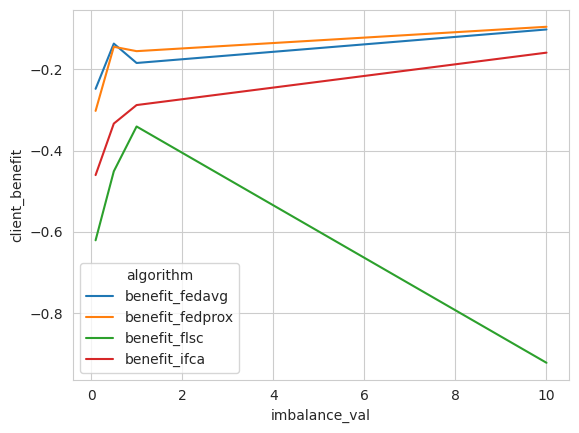

In [50]:
sns.lineplot(avg_benefits, x="imbalance_val", y="client_benefit", hue="algorithm")

## Benefit per Client

In [63]:
dataset = "mnist"
imbalance = "label_distribution"
imbalance_val = 1
df = f1scores.query(f"imbalance == '{imbalance}' and imbalance_val == {imbalance_val}")
# df = f1scores.query(f"imbalance == '{imbalance}'")
imbalances = pd.read_csv(Path(RUNDIR, RUNID + "_data.csv"))
df = df.merge(imbalances)
df.head()

,client,imbalance,imbalance_val,f1_ifca,f1_flsc,f1_fedavg,f1_local,f1_fedprox,benefit_fedavg,benefit_fedprox,benefit_ifca,benefit_flsc,dataset,imbalance_type,imbalance_value,label_imbalance,label_distribution_imbalance,quantity_imbalance
0,1,label_distribution,1.0,0.504304,0.449049,0.532118,0.777392,0.555324,-0.245274,-0.222068,-0.273088,-0.328343,mnist,label_distribution,10.0,3.709678,0.069274,0.898333
1,1,label_distribution,1.0,0.504304,0.449049,0.532118,0.777392,0.555324,-0.245274,-0.222068,-0.273088,-0.328343,mnist,label_distribution,0.1,1865.000000,0.681807,3.208333
2,1,label_distribution,1.0,0.504304,0.449049,0.532118,0.777392,0.555324,-0.245274,-0.222068,-0.273088,-0.328343,mnist,label_distribution,1.0,65.000000,0.337823,0.866667
3,1,label_distribution,1.0,0.504304,0.449049,0.532118,0.777392,0.555324,-0.245274,-0.222068,-0.273088,-0.328343,mnist,label_distribution,0.5,137.000000,0.363605,0.606667
4,6,label_distribution,1.0,0.513041,0.485940,0.678391,0.918155,0.720837,-0.239764,-0.197318,-0.405113,-0.432214,mnist,label_distribution,10.0,1.790698,0.019479,0.966667


In [65]:
import plotly.express as px
px.scatter(df, x="label_distribution_imbalance", y="benefit_fedprox", trendline="ols")

## Cluster Assignments

In [ ]:
n_clusters = 5
cluster_assignments

In [ ]:
def extract_cluster_assignments(ca):
    if isinstance(ca, str):
        return list(map(int, ca.split("|")))
    else:
        return int(ca)

cluster_assignments["clusters"] = cluster_assignments["value"].apply(extract_cluster_assignments)
cluster_assignments = cluster_assignments[["round", "client", "algorithm", "imbalance", "imbalance_val", "clusters"]]

In [ ]:
ca_ifca = cluster_assignments.query("algorithm == 'IFCA'")
ca_flsc = cluster_assignments.query("algorithm == 'FLSC'").explode("clusters")

In [ ]:
df = ca_ifca.groupby(["round", "algorithm", "imbalance", "imbalance_val", "clusters"]).size().reset_index().rename(columns={0: 'count'})
df

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

px.area(df.query("imbalance_val == 0.1"), x="round", y="count", color="clusters")

In [ ]:
px.line(ca_ifca.query("imbalance_val == 0.1"), x="round", y="clusters", color="client")

In [ ]:
df = ca_flsc.groupby(["round", "algorithm", "imbalance", "imbalance_val", "clusters"]).size().reset_index().rename(columns={0: 'count'})
px.area(df.query("imbalance_val == 0.1"), x="round", y="count", color="clusters")

In [ ]:
cluster_assignments.query("algorithm == 'FLSC'")